In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely

import matplotlib.pyplot as plt

<AxesSubplot:>

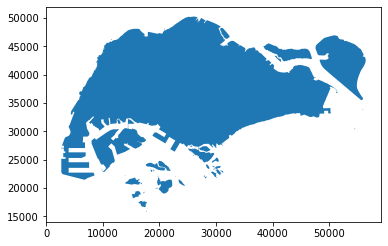

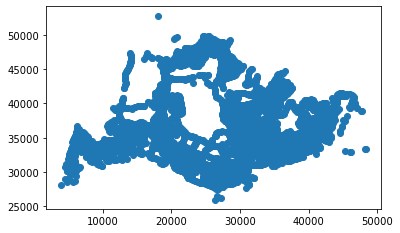

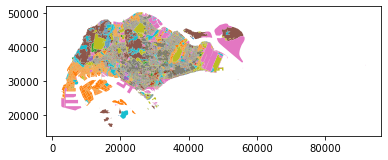

In [2]:
# Example

# read boundary
file_path = "zip://data/MP2019-boundray-zone-SVY21.zip!MP2019-boundray-zone-SVY21/MP2019-boundary/MP2019-boundary.shp"
boundary_gdf = gpd.read_file(file_path)
boundary_gdf.plot()

# read bus stop location
file_path = "zip://data/Bus Network Shapefile.zip!Bus Network Shapefile/bus_stop/bus_stop.shp"
stop_gpd = gpd.read_file(file_path)
stop_gpd.plot()

# read land use
file_path = "zip://data/MP2019-landuse-SVY21.zip!MP2019-landuse-SVY21/MP2019-landuse-SVY21.shp"
landuse_gpd = gpd.read_file(file_path)
landuse_gpd.plot(column='type', categorical=True)

# 1 Grid

- generate mesh grids within a given  boundary


**Note:**

- "boundary" should be in a **projected coordinate system**

- the return **doesn't** contain CRS information

**Examples:**

- **Example 1:** Generate grids in a box of (0, 5000, 0, 5000)

```python
# x_min, x_max, y_min, y_max
box = (0, 5000, 0, 5000)
grid = creat_mesh_grid(box=box)
grid.plot()
```

- **Example 2:** Gridding a polygon

```python
grid = creat_mesh_grid(boundary=boundary)
grid.plot()
```

- **Example 3:** Consider both

```python
grid = creat_mesh_grid(box=box, boundary=boundary)
grid.plot()
```

In [49]:
def creat_mesh_grid(box=None, boundary=None, width=200, heigth=200):
    '''
    creat mesh grids
    
    parameters:
    -----------
    width, heigth (float) : 
        the width and heigh of the grid
    box (four elements tuple, float): (x_min, x_max, y_min, y_max): 
        a rectangular boundary, 
        left-bottom point (x_min, y_min) ->  right-top point (x_max, y_max)
    boundary (shapely.geometry.Polygon or shapely.geometry.MultiPolygon) : 
        a boundary

    Return:
    -------
    grids (geopandas.GeoDataFrame) :
        doesn't contain CRS information
    '''
    from shapely.geometry import Polygon, MultiPolygon
    
    if not(boundary is None):
        assert isinstance(boundary, Polygon) or isinstance(boundary, MultiPolygon)
    
    # at least one of "box" and "boundary" is not None
    assert (box is None) + (boundary is None) <= 1
    
    # grid
    if (not (box is None)) and (boundary is None):
        x_min, x_max, y_min, y_max = box
    elif (box is None) and (not (boundary is None)):
        bou_x, bou_y = boundary_geo.envelope.exterior.coords.xy
        x_min, x_max = min(bou_x), max(bou_x)
        y_min, y_max = min(bou_y), max(bou_y)
    # both "box" and "boundary" are considerred
    if (not (box is None)) and (not (boundary is None)):
        x_min_box, x_max_box, y_min_box, y_max_box = box
        
        bou_x, bou_y = boundary_geo.envelope.exterior.coords.xy
        x_min_bou, x_max_bou = min(bou_x), max(bou_x)
        y_min_bou, y_max_bou = min(bou_y), max(bou_y)
        
        x_min = max(x_min_bou, x_min_box)
        x_max = min(x_max_bou, x_max_box)
        y_min = max(y_min_bou, y_min_box)
        y_max = min(y_max_bou, y_max_box)
    
    grid_li = []
    
    n_row = int((x_max - x_min) // width + 1)
    n_col = int((y_max - y_min) // heigth + 1)
    
    for i in range(n_row):
        for j in range(n_col):
            x_1 = x_min + i * width
            y_1 = y_min + j * heigth
            
            polygon = Polygon([(x_1, y_1), (x_1+width, y_1), (x_1+width, y_1+heigth), (x_1, y_1+heigth)])
            grid_li.append(polygon)
    
    grid_gpd = gpd.GeoSeries(grid_li)
    grid_gpd = gpd.GeoDataFrame(grid_gpd.area, 
                                columns  = ['area'], 
                                geometry = gpd.GeoSeries(grid_li).geometry)
    
    if not(boundary is None):
        grid_gpd['flag'] = grid_gpd.intersects(boundary)
        # select out
        grid_gpd = grid_gpd[grid_gpd['flag']]
        grid_gpd = grid_gpd.drop('flag', axis=1).reset_index(drop=True)
        # id
        grid_gpd['id'] = grid_gpd.index.to_list()
    
    return grid_gpd
# =================================================

## 1.2 Examples

<AxesSubplot:>

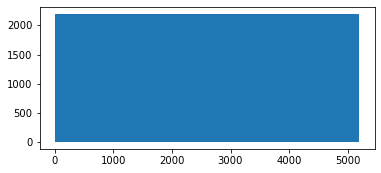

In [78]:
# x_min, x_max, y_min, y_max
box = (0, 5000, 0, 2000)
grid = creat_mesh_grid(box=box)
grid.plot()

<AxesSubplot:>

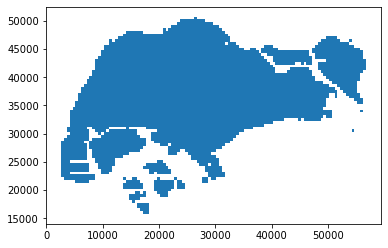

In [79]:
boundary_geo = boundary_gdf['geometry'].values[0]
grid = creat_mesh_grid(boundary=boundary_geo, width=500, heigth=500)
grid.plot()

<AxesSubplot:>

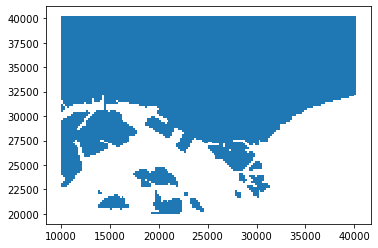

In [84]:
box = (10000, 40000, 20000, 40000)
boundary_geo = boundary_gpd['geometry'].values[0]

grid_gpd = creat_mesh_grid(box=box, boundary=boundary_geo)
grid_gpd.plot()

# 2 Voronoi

- generate Voronoi diagrams with boundary and maximum distance


**Note:**

- "node_gpd", and "boundary" should be in a **projected coordinate system** and in the same CRS

- the return **contains** CRS information

**Examples:**

- **Example 1:** Generate Voronoi

```python
voronoi = generate_voronoi(node_gpd=stop_gpd)
voronoi.plot()
```

- **Example 2:** Generate Voronoi with boundary

```python
voronoi = generate_voronoi(node_gpd=stop_gpd, boundary=boundary)
voronoi.plot()
```

- **Example 3:** Consider both

```python
voronoi = generate_voronoi(node_gpd=stop_gpd, max_dist=400, boundary=boundary)
voronoi.plot()
```

In [161]:
def generate_voronoi(node_gpd, max_dist=None, boundary=None):
    '''
    creat mesh grids
    
    parameters:
    -----------
    node_gpd (geopandas.GeoDataFrame) : 
        nodes, with CRS information
    max_dist (float, default is None): 
        maximum distance from nodes
    boundary (shapely.geometry.Polygon or shapely.geometry.MultiPolygon, default is None) : 
        a boundary, must share the same CRS with "node_gpd"

    Return:
    -------
    voro (geopandas.GeoDataFrame) :
        
    '''
    from shapely.geometry import MultiPoint, Polygon, MultiPolygon
    from shapely.ops import voronoi_diagram
    
    # voronoi
    points = MultiPoint(node_gpd['geometry'].to_list())
    voro = voronoi_diagram(points)
    # 
    voro = gpd.GeoSeries(list(voro.geoms))
    voro = gpd.GeoDataFrame(list(range(voro.shape[0])), 
                            columns  = ['voro_id'], 
                            geometry = voro.geometry,
                            crs      = node_gpd.crs)
    
    # join voronoi and node
    voro = voro.sjoin(df = node_gpd, 
                      predicate = 'intersects', 
                      how       = 'left',
                      rsuffix   = 'node',
                      lsuffix   = 'voro')
    
    # use original node index
    voro = voro.set_index('index_node').sort_index()
    
    if not (max_dist is None):
        buffer = node_gpd.buffer(max_dist)
        # intersection
        voro['geometry'] = voro.intersection(buffer, align=True)
    
    # clip
    if not (boundary is None):
        assert isinstance(boundary, Polygon) or isinstance(boundary, MultiPolygon)
        voro = voro.clip(boundary)
        
    return voro

## 2.2 Examples

<AxesSubplot:>

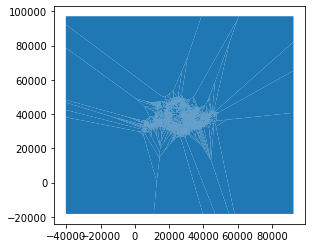

In [168]:
voronoi = generate_voronoi(stop_gpd)

voronoi.plot()

<AxesSubplot:>

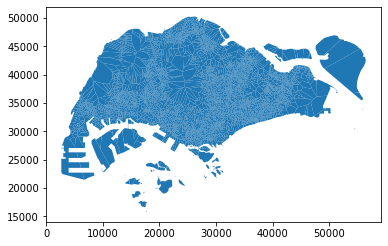

In [169]:
boundary_geo = boundary_gpd['geometry'].values[0]

stop_voro = generate_voronoi(stop_gpd, boundary=boundary_geo)

# stop_voro.to_file(r'generated_data/stop_voro_with_boundary')

stop_voro.plot()

<AxesSubplot:>

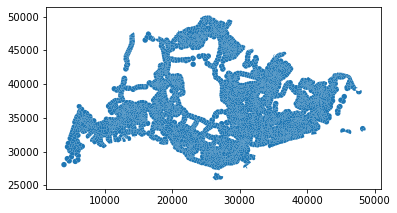

In [170]:
boundary_geo = boundary_gpd['geometry'].values[0]

stop_voro = generate_voronoi(stop_gpd, max_dist=400, boundary=boundary_geo)

# stop_voro.to_file(r'generated_data/stop_voro_with_boundary_dist')

stop_voro.plot()

# 3 Overlay

- Calculate the overlay of two polygon layers

- References: [Overlay](https://geopandas.org/en/stable/docs/user_guide/set_operations.html), [geopandas.GeoDataFrame.overlay](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.overlay.html)


In [199]:
def overlay_zone_category(zone_gdf, category_gdf):
    '''
    zone_gdf (geopandas.GeoDataFrame): 
        layer 1, zone information
    category_gdf (geopandas.GeoDataFrame):
        layer 2, contain information
        
    Return:
    -------
    zone_cate_gdf (geopandas.GeoDataFrame) :
        
    '''
    zone_cate_gdf = zone_gdf.overlay(category_gdf, how='intersection', keep_geom_type=True, make_valid=True)
    
    return zone_cate_gdf
# ===================================================================


def agg_zone_info(zone_cate_gdf, zone_col, info_col, value_col):
    '''
    zone_cate_gdf (geopandas.GeoDataFrame): 
        joint zone and category information
    zone_col, info_col, value_col (str):
        zone_col: zone id
        
    Return:
    -------
    zone_info (geopandas.GeoDataFrame) :  
    '''
    zone_cate_gdf = zone_cate_gdf[[zone_col, info_col, value_col]]
    
    # 
    zone_cate_gdf = zone_cate_gdf.groupby([zone_col, info_col], as_index=False).sum()
    
    # pivot table
    zone_info = zone_cate_gdf.pivot(index=zone_col, columns=info_col, values=value_col)
    
    # fill NAN cell
    zone_info = zone_info.fillna(0.)
    
    return zone_info

## 3.2 Examples

In [200]:
boundary_geo = boundary_gpd['geometry'].values[0]
stop_voro = generate_voronoi(stop_gpd, boundary=boundary_geo)

# zone layer
zone_gdf = stop_voro

# information layer, e.g., land use
category_gdf = landuse_gpd

# overlay
zone_cate_gdf = overlay_zone_category(zone_gdf, category_gdf)
zone_cate_gdf.to_file('generated_data/zone_category')

# value: area
zone_cate_gdf['area'] = zone_cate_gdf.area

# 
zone_info = agg_zone_info(zone_cate_gdf, zone_col='voro_id', info_col='type', value_col='area')

zone_info

type,AGRICULTURE,BEACH AREA,BUSINESS 1,BUSINESS 1 - WHITE,BUSINESS 2,BUSINESS 2 - WHITE,BUSINESS PARK,BUSINESS PARK - WHITE,CEMETERY,CIVIC & COMMUNITY INSTITUTION,...,RESIDENTIAL,RESIDENTIAL / INSTITUTION,RESIDENTIAL WITH COMMERCIAL AT 1ST STOREY,ROAD,SPECIAL USE,SPORTS & RECREATION,TRANSPORT FACILITIES,UTILITY,WATERBODY,WHITE
voro_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,2.325142e+05,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,30451.027964,3.315363e+03,0.000000,0.000000,163114.970475,0.000000,0.0
1,0.0,0.0,0.0,0.0,3.036713e+06,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,435651.209965,0.000000e+00,0.000000,0.000000,0.000000,24202.270289,0.0
2,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,181.965310,...,134452.362472,0.0,0.0,30572.430154,0.000000e+00,6295.183931,0.000000,0.000000,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,941.067556,...,234357.889300,0.0,0.0,34897.729494,0.000000e+00,0.000000,1717.677455,0.000000,23233.006898,0.0
4,0.0,0.0,0.0,0.0,6.521266e+05,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,131384.399583,0.000000e+00,0.000000,0.000000,0.000000,2473.571001,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5077,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,223739.369578,1.948428e+06,0.000000,569589.977944,2960.027741,118240.848074,0.0
5078,0.0,0.0,0.0,0.0,3.401136e+04,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,14432.139010,0.000000e+00,0.000000,0.000000,3142.578572,0.000000,0.0
5079,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,24943.516540,0.000000e+00,0.000000,0.000000,0.000000,7975.150099,0.0


In [204]:
# zone layer
zone_gdf = stop_gpd.copy()
zone_gdf['geometry'] = stop_gpd.buffer(400.)

# information layer, e.g., land use
category_gdf = landuse_gpd

# overlay
zone_cate_gdf = overlay_zone_category(zone_gdf, category_gdf)
zone_cate_gdf.to_file('generated_data/buffer_category')

# value: area
zone_cate_gdf['area'] = zone_cate_gdf.area

# 
zone_info = agg_zone_info(zone_cate_gdf, zone_col='BusStopCod', info_col='type', value_col='area')

zone_info.sum(axis=1).sort_values().plot()

zone_info

type,AGRICULTURE,BEACH AREA,BUSINESS 1,BUSINESS 1 - WHITE,BUSINESS 2,BUSINESS 2 - WHITE,BUSINESS PARK,BUSINESS PARK - WHITE,CEMETERY,CIVIC & COMMUNITY INSTITUTION,...,RESIDENTIAL,RESIDENTIAL / INSTITUTION,RESIDENTIAL WITH COMMERCIAL AT 1ST STOREY,ROAD,SPECIAL USE,SPORTS & RECREATION,TRANSPORT FACILITIES,UTILITY,WATERBODY,WHITE
BusStopCod,,,,,,,,,,,,,,,,,,,,,
01012,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37682.873969,...,0.000000,0.0,8030.190589,158004.378162,0.000000,0.000000,0.0,8097.314990,0.000000,110.123193
01013,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35034.076276,...,0.000000,0.0,15096.064362,156553.742196,0.000000,0.000000,0.0,5444.663721,0.000000,2.842583
01019,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34496.624182,...,0.000000,0.0,12733.622341,159044.175453,0.000000,0.000000,0.0,7787.821985,0.000000,0.000000
01029,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23868.442964,...,0.000000,0.0,20512.102681,159201.252970,0.000000,0.000000,0.0,4349.562183,0.000000,0.000000
01039,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16145.868967,...,0.000000,0.0,21788.674396,170934.246683,0.000000,0.000000,0.0,1658.476940,0.000000,21309.527522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99139,0.0,76.016796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,49190.081501,0.0,0.000000,90711.025134,115817.710370,97218.805498,0.0,0.000000,21244.895902,0.000000
99161,0.0,46912.535874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,54165.752611,173.416075,2699.426056,0.0,0.000000,17137.553301,0.000000
99171,0.0,39422.938599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,49755.207827,1088.326519,8225.547056,0.0,0.000000,31606.251425,0.000000


# 4 Delaunay triangulation

In [35]:
def delaunay_triangulation(node_gpd, node_id, return_type='polygon', boundary=None):
    '''
    creat delaunay triangulation
    
    parameters:
    -----------
    node_gpd (geopandas.GeoDataFrame) : 
        nodes (shapely.geometry.Point), with CRS information
    node_id (str): 
        column name of node id
    return_type (str, default=polygon, {'polygon', 'line_string', 'line_segement'}):
        'polygon' : 
        'line_string' : 
        'line_segement' : contain two directions share the same line
    boundary (shapely.geometry.Polygon or shapely.geometry.MultiPolygon, default is None) : 
        a boundary, must share the same CRS with "node_gpd"

    Return:
    -------
    triangle (geopandas.GeoDataFrame) :
        
    '''
    from shapely.geometry import LineString, Point, Polygon, MultiPolygon
    # from shapely.ops import Delaunay
    from scipy.spatial import Delaunay 
    
    # node index and id
    node_id_mapper = {k : v for k, v in enumerate(node_gpd[node_id].to_list())}
    # 
    node_coors = {k : v.coords[0] for k, v in enumerate(node_gpd['geometry'].to_list())}
    # print(node_coors[0])
    
    # coordinates of points
    points = np.concatenate((node_gpd['geometry'].x.values.reshape(-1, 1), 
                             node_gpd['geometry'].y.values.reshape(-1, 1)), axis=1)
    
    triangle = pd.DataFrame(Delaunay(points).simplices, 
                            columns=['point_1', 'point_2', 'point_3'])
    
    if return_type == 'polygon':

        triangle['geometry'] = triangle[['point_1', 'point_2', 'point_3']].apply(
            lambda x: Polygon([node_coors[i] for i in x.to_list()]),
            axis='columns')
        
        triangle[['point_1', 'point_2', 'point_3']] = triangle[['point_1', 'point_2', 'point_3']].applymap(lambda x : node_id_mapper[x])

    elif return_type == 'line_string':

        triangle['geometry'] = triangle[['point_1', 'point_2', 'point_3', 'point_1']].apply(
            lambda x: LineString([node_coors[i] for i in x.to_list()]),
            axis='columns')

        triangle[['point_1', 'point_2', 'point_3']] = triangle[['point_1', 'point_2', 'point_3']].applymap(lambda x : node_id_mapper[x])

    elif return_type == 'line_segement':

        triangle = pd.DataFrame(
            np.concatenate((triangle[['point_1', 'point_2']].values, 
                            triangle[['point_2', 'point_3']].values, 
                            triangle[['point_1', 'point_3']].values), axis=0),
            columns = ['point_1', 'point_2'])
        
        # inverse direction
        triangle_ = triangle.copy().rename({'point_1': 'point_2', 'point_2': 'point_1'}, axis='columns')
        # merge two direction
        triangle = pd.concat([triangle, triangle_], axis=0, ignore_index=True)
        # drop duplicate edge
        triangle = triangle.drop_duplicates(ignore_index=True)
        
        # geometry information
        triangle['geometry'] = triangle[['point_1', 'point_2']].apply(
            lambda x: LineString([node_coors[i] for i in x.to_list()]),
            axis='columns')
        
        triangle[['point_1', 'point_2']] = triangle[['point_1', 'point_2']].applymap(lambda x : node_id_mapper[x])
    
    # create gpd.GeoDataFrame
    triangle = gpd.GeoDataFrame(triangle.drop(['geometry'], axis=1), 
                                geometry = triangle['geometry'],
                                crs = node_gpd.crs)
    
    # clip
    if not (boundary is None):
        assert isinstance(boundary, Polygon) or isinstance(boundary, MultiPolygon)
        
        # triangle = triangle.clip(boundary) # quite time-consuming if "boundary" is complex
        
        ix = triangle.centroid.sindex.query(landuse_road, predicate='intersects')
        triangle = triangle.reindex(ix).sort_index().reset_index()
    
    return triangle

## 4.2 Example

In [38]:
node_id = 'BusStopCod'
return_type = 'polygon' #'line_string', 'line_segement', 'polygon'

triangle = delaunay_triangulation(stop_gpd, node_id, return_type)

# triangle.to_file(r'generated_data\triangle_busstop_'+return_type)